In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import geoplot
import geopandas
import pycountry
from github import Github
from datetime import datetime
from functools import reduce

plt.rcParams["figure.figsize"] = (16, 10)

In [3]:
who_daily_reports_dir_name = "who_daily_reports"

# WHO daily reports data download

In [4]:
who_repo_name = "CSSEGISandData/COVID-19"
who_repo_daily_reports_dir_path = "csse_covid_19_data/csse_covid_19_daily_reports"

In [5]:
# github = Github("user", "password") # Using authenticated connection changes api limit from 60 per hour to 5000 per hour
github = Github()
repo = github.get_repo(who_repo_name)
reports_dir_content = repo.get_contents(who_repo_daily_reports_dir_path)
reports = list(filter(lambda report: ".csv" in report.name, reports_dir_content))
reports[:5]

[ContentFile(path="csse_covid_19_data/csse_covid_19_daily_reports/01-22-2020.csv"),
 ContentFile(path="csse_covid_19_data/csse_covid_19_daily_reports/01-23-2020.csv"),
 ContentFile(path="csse_covid_19_data/csse_covid_19_daily_reports/01-24-2020.csv"),
 ContentFile(path="csse_covid_19_data/csse_covid_19_daily_reports/01-25-2020.csv"),
 ContentFile(path="csse_covid_19_data/csse_covid_19_daily_reports/01-26-2020.csv")]

In [6]:
try:
    os.mkdir(who_daily_reports_dir_name)
    print("Created directory", who_daily_reports_dir_name)
except FileExistsError:
    print('WHO daily reports directory already exists')
    
for report in reports:
    try:
        report_file_path = os.path.join(who_daily_reports_dir_name, report.name)
        report_file = open(report_file_path, 'x')
        report_file.write(report.decoded_content.decode('utf-8'))
        report_file.close()
        print("Created report file", report_file_path)
    except FileExistsError:
        print("Daily report file", report_file_path, "already exists")
    except RateLimitExceededException:
        print("API rate limit exceeded, try again in an hour")
        report_file.close()
        os.remove(report_file_path)
        break

WHO daily reports directory already exists
Daily report file who_daily_reports/01-22-2020.csv already exists
Daily report file who_daily_reports/01-23-2020.csv already exists
Daily report file who_daily_reports/01-24-2020.csv already exists
Daily report file who_daily_reports/01-25-2020.csv already exists
Daily report file who_daily_reports/01-26-2020.csv already exists
Daily report file who_daily_reports/01-27-2020.csv already exists
Daily report file who_daily_reports/01-28-2020.csv already exists
Daily report file who_daily_reports/01-29-2020.csv already exists
Daily report file who_daily_reports/01-30-2020.csv already exists
Daily report file who_daily_reports/01-31-2020.csv already exists
Daily report file who_daily_reports/02-01-2020.csv already exists
Daily report file who_daily_reports/02-02-2020.csv already exists
Daily report file who_daily_reports/02-03-2020.csv already exists
Daily report file who_daily_reports/02-04-2020.csv already exists
Daily report file who_daily_repor

# WHO daily reports parsing

In [7]:
column_names = ['Province/State', 'Country/Region', 'Confirmed', 'Deaths', 'Recovered']
new_column_names = ['Province_State', 'Country_Region', 'Confirmed', 'Deaths', 'Recovered']

reports_files_names = sorted(os.listdir(who_daily_reports_dir_name))
reports = []
for report_file_name in reports_files_names:
    date = datetime.strptime(report_file_name[:-4], '%m-%d-%Y')
    dataframe = pd.read_csv(os.path.join(who_daily_reports_dir_name, report_file_name))
    
    try:
        dataframe = dataframe[column_names]
    except KeyError:
        dataframe = dataframe[new_column_names]
        dataframe = dataframe.rename(columns={'Province_State': 'Province/State', 'Country_Region': 'Country/Region'})
    
    dataframe['Province/State'].fillna("NotSpecified", inplace=True)
    dataframe.fillna(0, inplace=True)

    dataframe = dataframe.astype({'Confirmed': 'int32', 'Deaths': 'int32', 'Recovered': 'int32'}, copy=False)
    
    reports.append((date, dataframe))
    
reports = np.array(reports)

In [8]:
reports[:5, 0]

array([datetime.datetime(2020, 1, 22, 0, 0),
       datetime.datetime(2020, 1, 23, 0, 0),
       datetime.datetime(2020, 1, 24, 0, 0),
       datetime.datetime(2020, 1, 25, 0, 0),
       datetime.datetime(2020, 1, 26, 0, 0)], dtype=object)

In [9]:
reports[1, 1].head()

,Province/State,Country/Region,Confirmed,Deaths,Recovered
0,Anhui,Mainland China,9,0,0
1,Beijing,Mainland China,22,0,0
2,Chongqing,Mainland China,9,0,0
3,Fujian,Mainland China,5,0,0
4,Gansu,Mainland China,2,0,0


In [10]:
reports[0, 1].dtypes

Province/State    object
Country/Region    object
Confirmed          int32
Deaths             int32
Recovered          int32
dtype: object

# Plotting COVID data for whole world

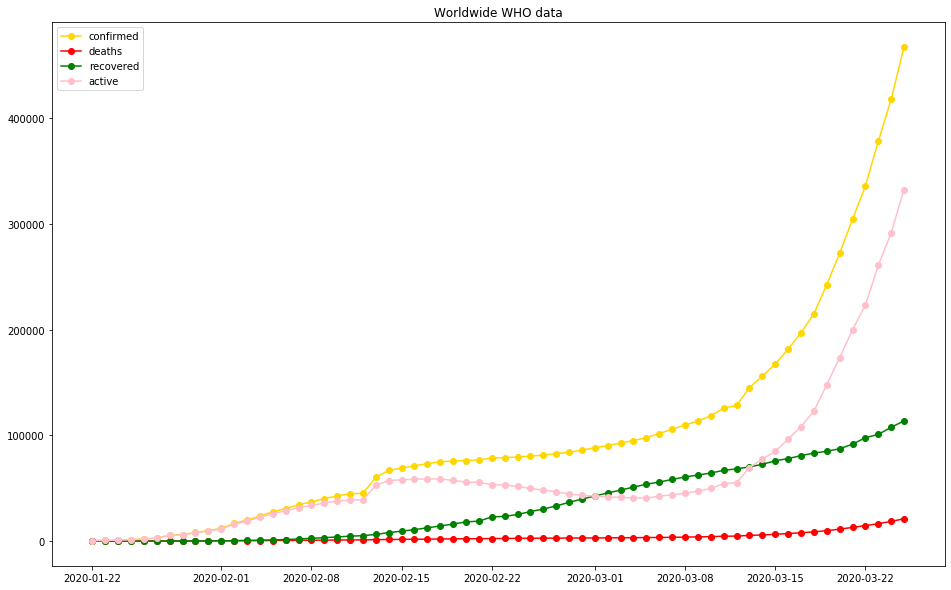

In [11]:
world_confirmed = []
world_deaths = []
world_recovered = []
world_active = []

for report in reports[:, 1]:
    world_stats = report.sum()
    world_confirmed.append(world_stats['Confirmed'])
    world_deaths.append(world_stats['Deaths'])
    world_recovered.append(world_stats['Recovered'])
    world_active.append(world_confirmed[-1] - world_deaths[-1] - world_recovered[-1])

fig, ax = plt.subplots(1, 1)
ax.set_title('Worldwide WHO data')
ax.plot(reports[:, 0], world_confirmed, 'o-', c='gold', label='confirmed')
ax.plot(reports[:, 0], world_deaths, 'o-', c='red', label='deaths')
ax.plot(reports[:, 0], world_recovered, 'o-', c='green', label='recovered')
ax.plot(reports[:, 0], world_active, 'o-', c='pink', label='active')
ax.legend()
plt.show()

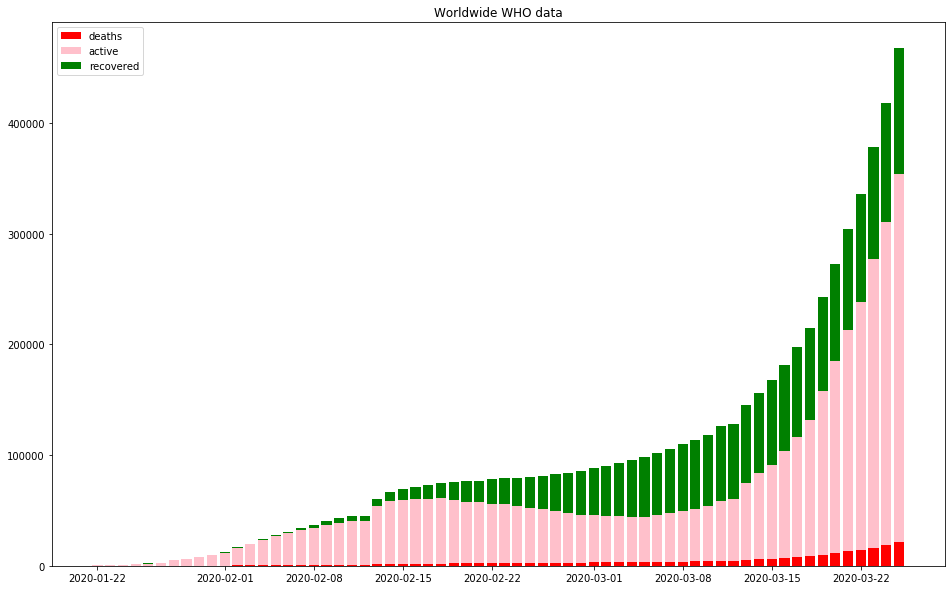

In [12]:
fig, ax = plt.subplots(1, 1)
ax.set_title('Worldwide WHO data')
ax.bar(reports[:, 0], world_deaths, color='red', label='deaths')
ax.bar(reports[:, 0], world_active, color='pink', bottom=world_deaths, label='active')
active_and_deaths = np.array(world_active) + np.array(world_deaths)
ax.bar(reports[:, 0], world_recovered, color='green', bottom=active_and_deaths, label='recovered')
ax.legend()
plt.show()

# Plotting COVID data for certain regions

In [13]:
def plot_for_region(regions_list, plot_active=False, plot_confirmed=True):
    confirmed = []
    deaths = []
    recovered = []
    active = []

    for report in reports[:, 1]:
        region_aggregated_stats = report.groupby('Country/Region').sum()
        stats = region_aggregated_stats.reindex(regions_list).fillna(0).astype('int32').sum()
        confirmed.append(stats['Confirmed'])
        deaths.append(stats['Deaths'])
        recovered.append(stats['Recovered'])
        active.append(confirmed[-1] - deaths[-1] - recovered[-1])

    fig, ax = plt.subplots(1, 1)
    if len(regions_list) > 1:
        ax.set_title('WHO data for regions: ' + reduce(lambda acc, val: acc + ', ' + val if acc != "" else val, regions_list, ""))
    else:
        ax.set_title('WHO data for the region ' + str(regions_list[0]))
                     
    if plot_confirmed:
        ax.plot(reports[:, 0], confirmed, 'o-', c='gold', label='confirmed')
    ax.plot(reports[:, 0], deaths, 'o-', c='red', label='deaths')
    ax.plot(reports[:, 0], recovered, 'o-', c='green', label='recovered')
    if plot_active:
        ax.plot(reports[:, 0], active, 'o-', c='pink', label='active')
    ax.legend()
    plt.show()

In [14]:
def barplot_for_region(regions_list):
    deaths = []
    recovered = []
    active = []

    for report in reports[:, 1]:
        region_aggregated_stats = report.groupby('Country/Region').sum()
        stats = region_aggregated_stats.reindex(regions_list).fillna(0).astype('int32').sum()
        deaths.append(stats['Deaths'])
        recovered.append(stats['Recovered'])
        active.append(stats['Confirmed'] - deaths[-1] - recovered[-1])

    fig, ax = plt.subplots(1, 1)
    if len(regions_list) > 1:
        ax.set_title('WHO data for regions: ' + reduce(lambda acc, val: acc + ', ' + val if acc != "" else val, regions_list, ""))
    else:
        ax.set_title('WHO data for the region ' + str(regions_list[0]))

    ax.bar(reports[:, 0], deaths, color='red', label='deaths')
    ax.bar(reports[:, 0], active, color='pink', bottom=deaths, label='active')
    active_and_deaths = np.array(active) + np.array(deaths)
    ax.bar(reports[:, 0], recovered, color='green', bottom=active_and_deaths, label='recovered')

    ax.legend()
    plt.show()

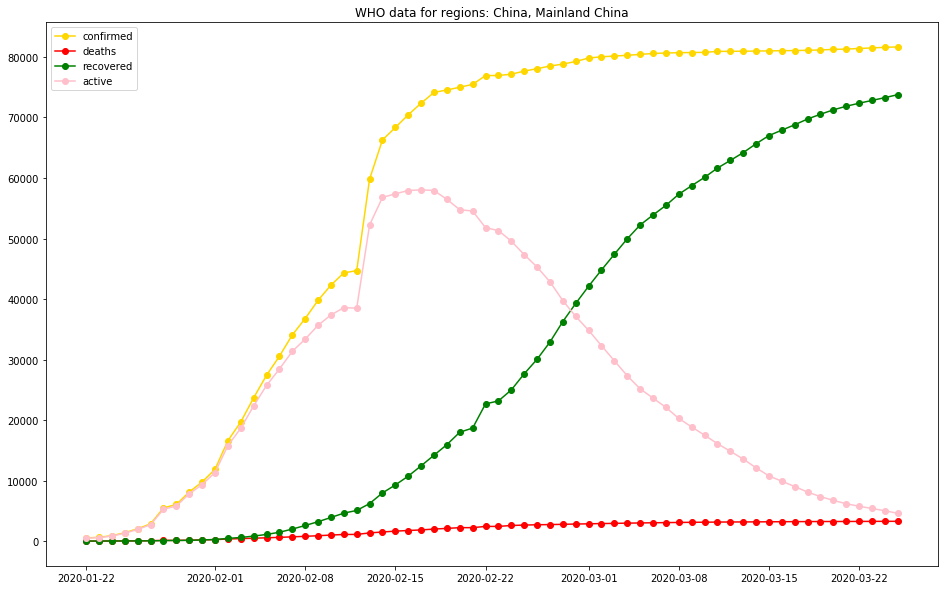

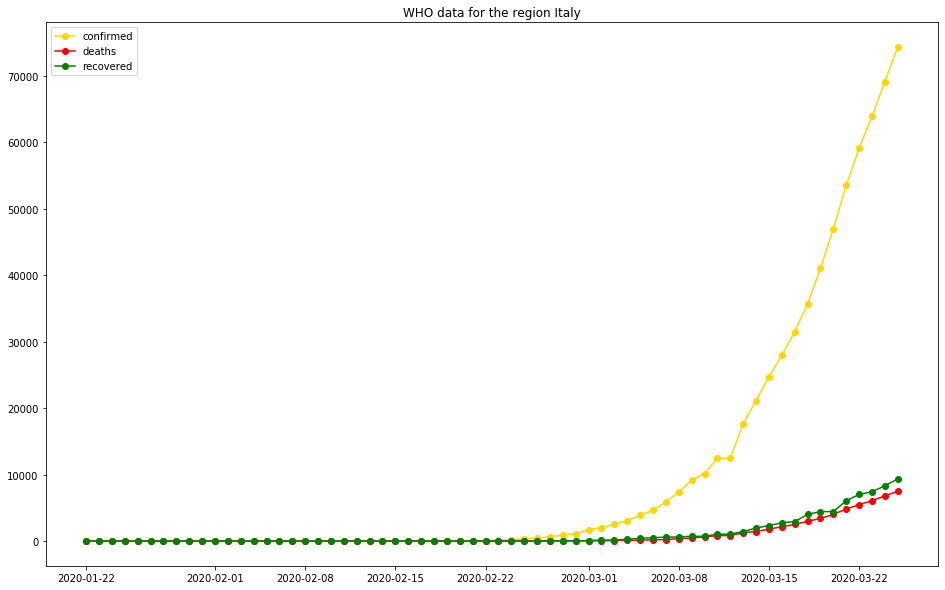

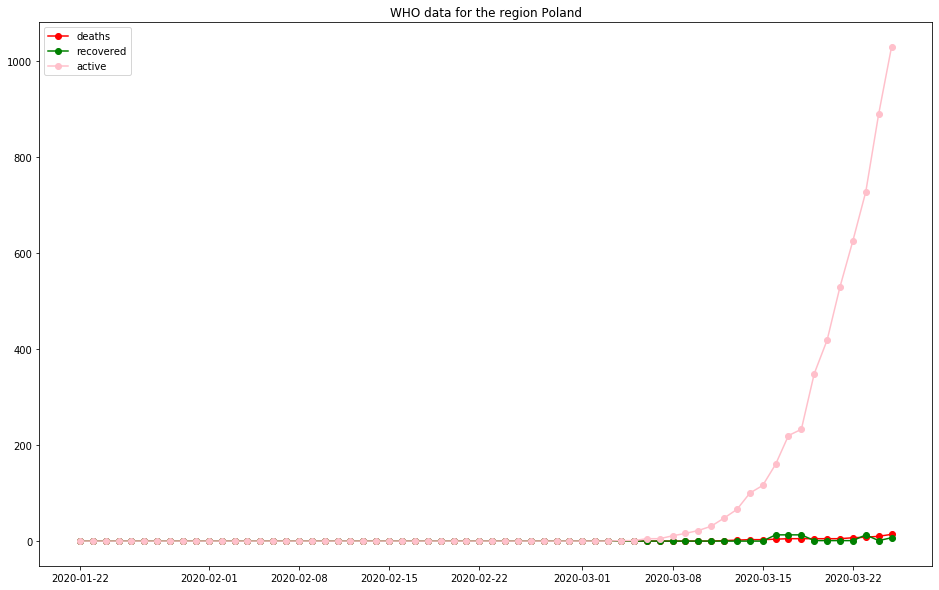

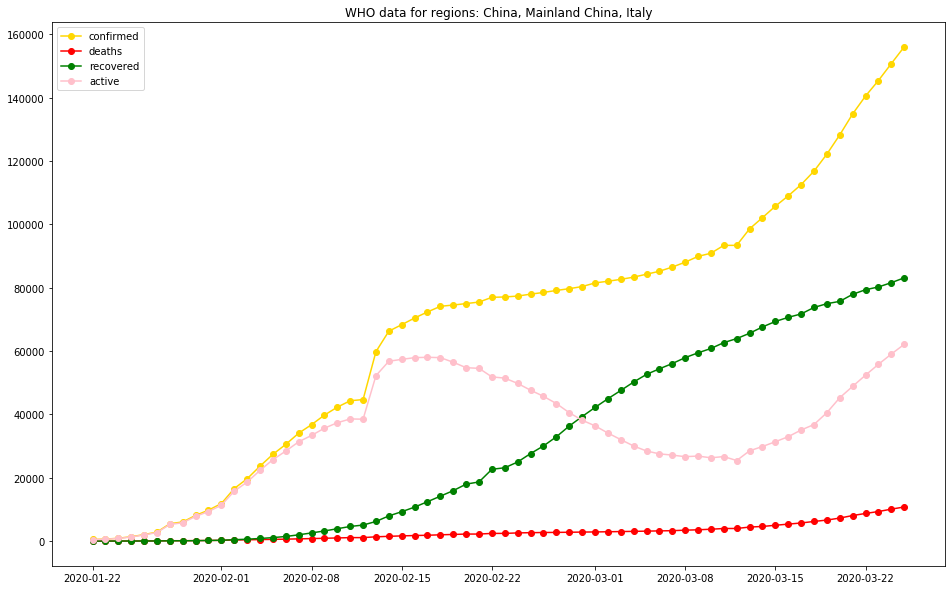

In [15]:
plot_for_region(['China', 'Mainland China'], plot_active=True)
plot_for_region(['Italy'])
plot_for_region(['Poland'], plot_active=True, plot_confirmed=False)
plot_for_region(['China', 'Mainland China', 'Italy'], plot_active=True)

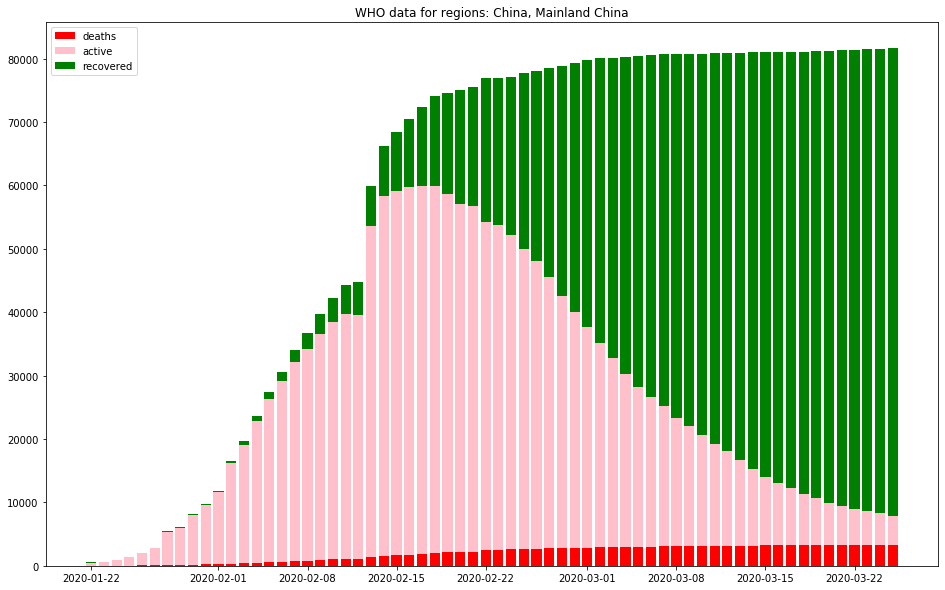

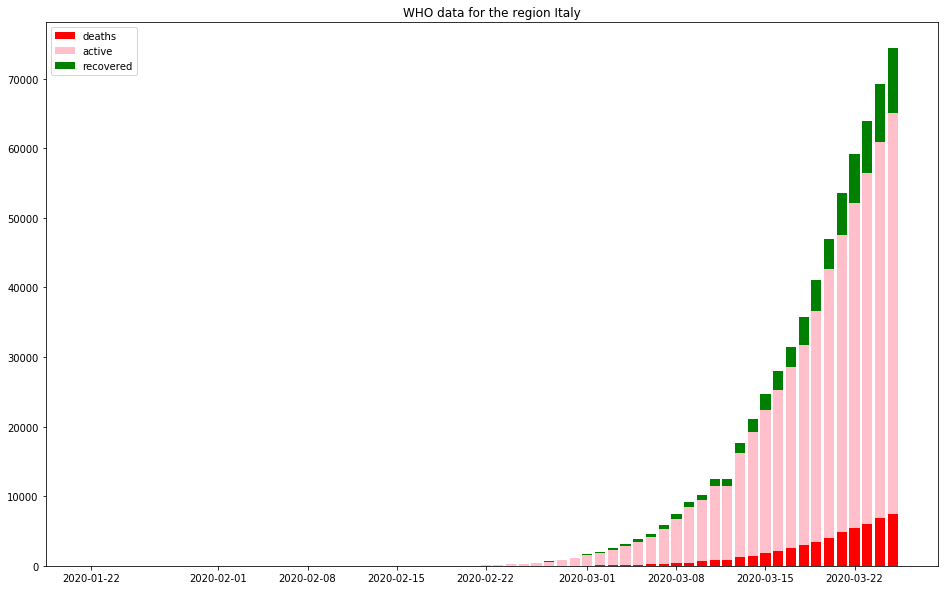

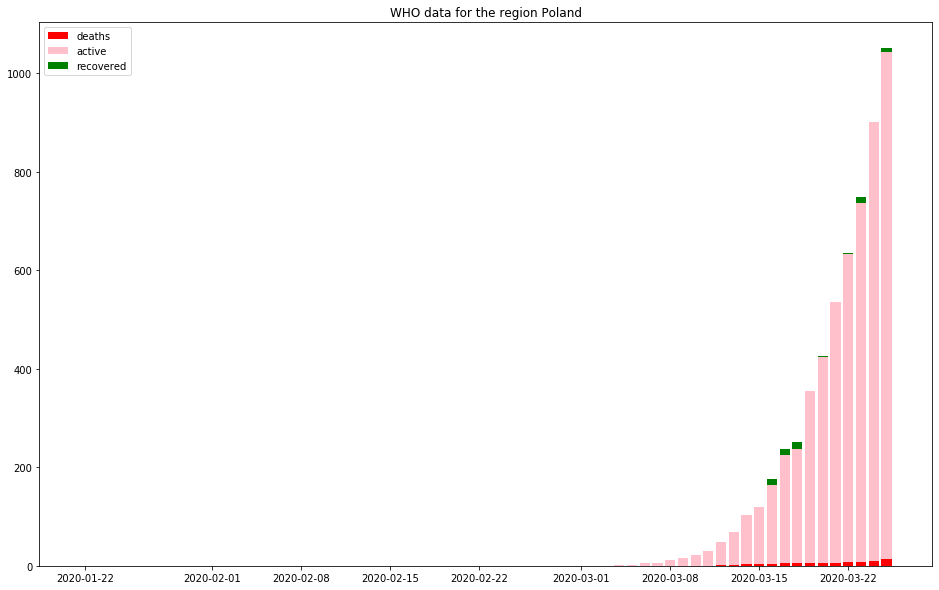

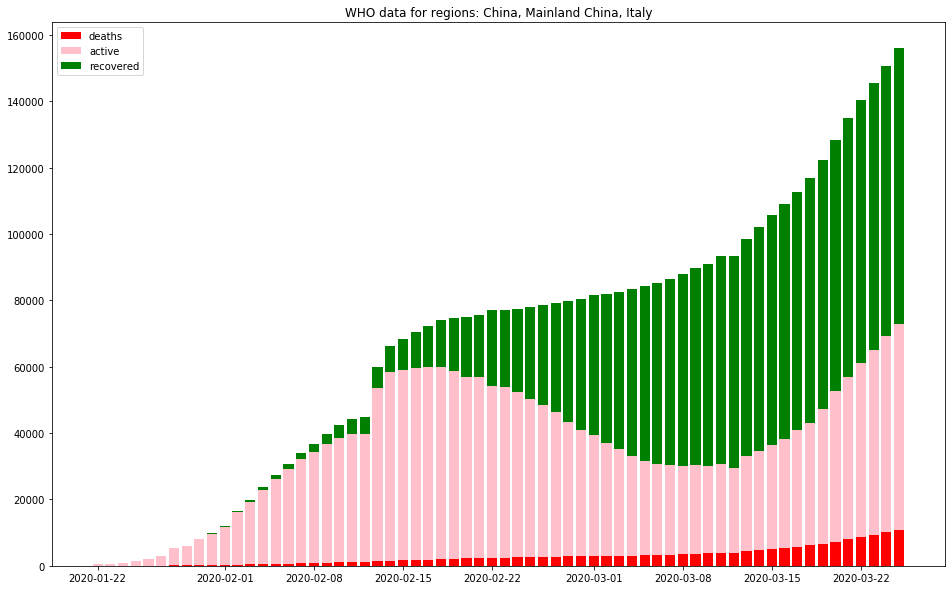

In [16]:
barplot_for_region(['China', 'Mainland China'])
barplot_for_region(['Italy'])
barplot_for_region(['Poland'])
barplot_for_region(['China', 'Mainland China', 'Italy'])

# Plotting latest WHO data on map 

### Getting geopandas world map dataframe

In [17]:
world_map_df = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))
world_map_df.head()

,pop_est,continent,name,iso_a3,gdp_md_est,geometry
0,920938,Oceania,Fiji,FJI,8374.0,"MULTIPOLYGON (((180.00000 -16.06713, 180.00000..."
1,53950935,Africa,Tanzania,TZA,150600.0,"POLYGON ((33.90371 -0.95000, 34.07262 -1.05982..."
2,603253,Africa,W. Sahara,ESH,906.5,"POLYGON ((-8.66559 27.65643, -8.66512 27.58948..."
3,35623680,North America,Canada,CAN,1674000.0,"MULTIPOLYGON (((-122.84000 49.00000, -122.9742..."
4,326625791,North America,United States of America,USA,18560000.0,"MULTIPOLYGON (((-122.84000 49.00000, -120.0000..."


### Preparing world map dataframe (unify countries names)

In [18]:
countries_proper_names = {
    'W. Sahara': 'Western Sahara',
    'Dem. Rep. Congo': 'Congo',
    'Dominican Rep.': 'Dominican Republic',
    'Falkland Is.': 'Falkland Islands (Malvinas)',
    'Fr. S. Antarctic Lands': 'Antarctica', #
    'Central African Rep.': 'Central African Republic',
    'Eq. Guinea': 'Equatorial Guinea',
    'Laos': 'Lao People\'s Democratic Republic',
    'North Korea': 'Korea, Democratic People\'s Republic of',
    'South Korea': 'Korea, Republic of',
    'Solomon Is.': 'Solomon Islands',
    'N. Cyprus': 'Cyprus', #
    'Somaliland': 'Somalia', #
    'Bosnia and Herz.': 'Bosnia and Herzegovina',
    'S. Sudan': 'South Sudan',
}


world_map_df.replace({'name': countries_proper_names}, inplace=True)
new_countries_names = [pycountry.countries.search_fuzzy(country)[0].name for country in world_map_df['name']]
world_map_df['name'] = new_countries_names
world_map_df.head()

,pop_est,continent,name,iso_a3,gdp_md_est,geometry
0,920938,Oceania,Fiji,FJI,8374.0,"MULTIPOLYGON (((180.00000 -16.06713, 180.00000..."
1,53950935,Africa,"Tanzania, United Republic of",TZA,150600.0,"POLYGON ((33.90371 -0.95000, 34.07262 -1.05982..."
2,603253,Africa,Western Sahara,ESH,906.5,"POLYGON ((-8.66559 27.65643, -8.66512 27.58948..."
3,35623680,North America,Canada,CAN,1674000.0,"MULTIPOLYGON (((-122.84000 49.00000, -122.9742..."
4,326625791,North America,United States,USA,18560000.0,"MULTIPOLYGON (((-122.84000 49.00000, -120.0000..."


### Preparing latest report data (unify countries names)

In [19]:
countries_to_remove = ['Diamond Princess']
countries_proper_names = {
    'Congo (Brazzaville)': 'Congo',
    'Congo (Kinshasa)': 'Congo',
    'Korea, South': 'Korea, Republic of',
    'Laos': 'Lao People\'s Democratic Republic',
    'Taiwan*': 'Taiwan, Province of China',
}

latest_report = reports[-1, 1].copy()[['Country/Region', 'Confirmed', 'Deaths', 'Recovered']]
latest_report = latest_report.loc[~latest_report['Country/Region'].isin(countries_to_remove), :]
latest_report.replace({'Country/Region': countries_proper_names}, inplace=True)
latest_report = latest_report.groupby('Country/Region', as_index=False).sum()
new_countries_names = [pycountry.countries.search_fuzzy(country)[0].name for country in latest_report['Country/Region']]
latest_report['Country/Region'] = new_countries_names
latest_report = latest_report.groupby('Country/Region', as_index=False).sum()
latest_report.head()

,Country/Region,Confirmed,Deaths,Recovered
0,Afghanistan,84,2,2
1,Albania,146,5,17
2,Algeria,302,21,65
3,Andorra,188,1,1
4,Angola,3,0,0


### Merging world map dataframe with latest WHO report dataframe

In [20]:
world_map_with_disease_data = world_map_df.join(latest_report.set_index("Country/Region"), on="name")
# Fill disease data for countries not included in report with 0
world_map_with_disease_data.fillna(0, inplace=True)

### Plotting disease data on world map

In [21]:
def plot_map(column_name, dataframe, title):
    fig, ax = plt.subplots(1, 1)
    ax.axis('off')
    ax.set_title(title, fontdict={'fontsize': '26'})
    dataframe.plot(column=column_name, cmap='Greys', linewidth=0.8, ax=ax, edgecolor='0.8', legend=True)
    plt.show()

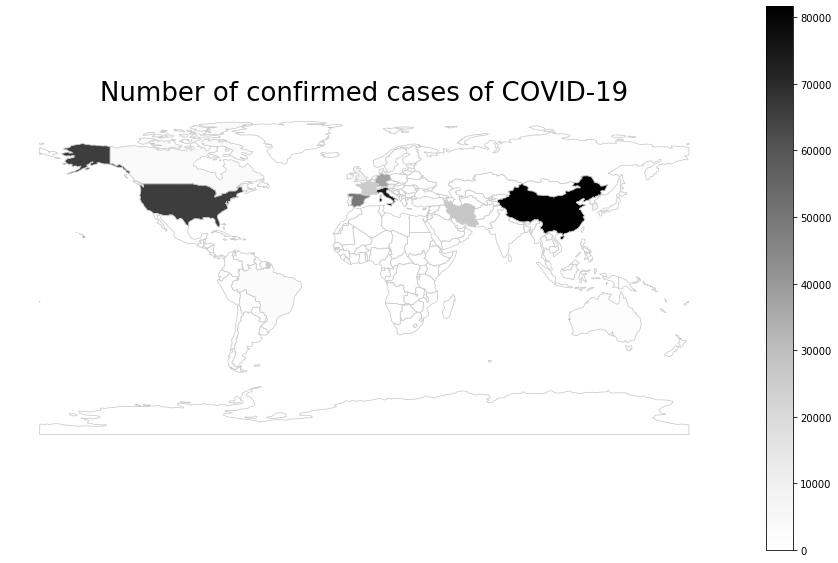

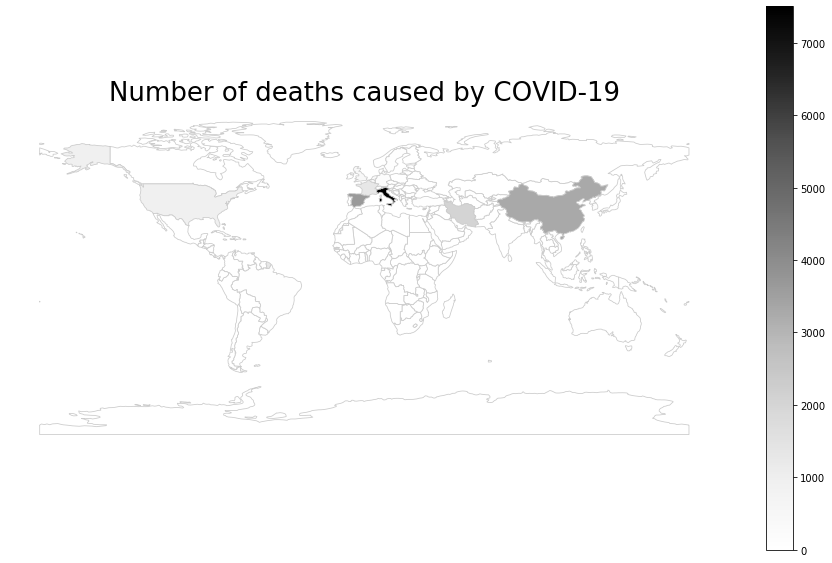

In [22]:
plot_map("Confirmed", world_map_with_disease_data, "Number of confirmed cases of COVID-19")   
plot_map("Deaths", world_map_with_disease_data, "Number of deaths caused by COVID-19")   

### Ploting disease data on Europe map (excluding Russia and French Guiana for clarity)

In [23]:
europe_stats_df = world_map_with_disease_data.loc[world_map_with_disease_data['continent'] == 'Europe', :]
europe_stats_df = europe_stats_df.loc[europe_stats_df['name'] != 'Russian Federation', :]
france_geometry_values = europe_stats_df.loc[europe_stats_df['name'] == 'France', 'geometry'].values
france_geometry_values[0] = france_geometry_values[0][1:]
europe_stats_df.loc[europe_stats_df['name'] == 'France', 'geometry'] = france_geometry_values

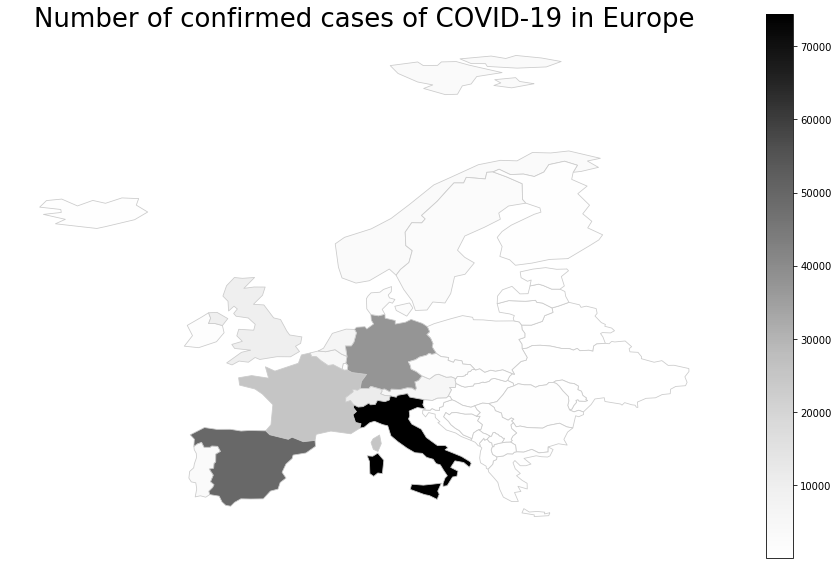

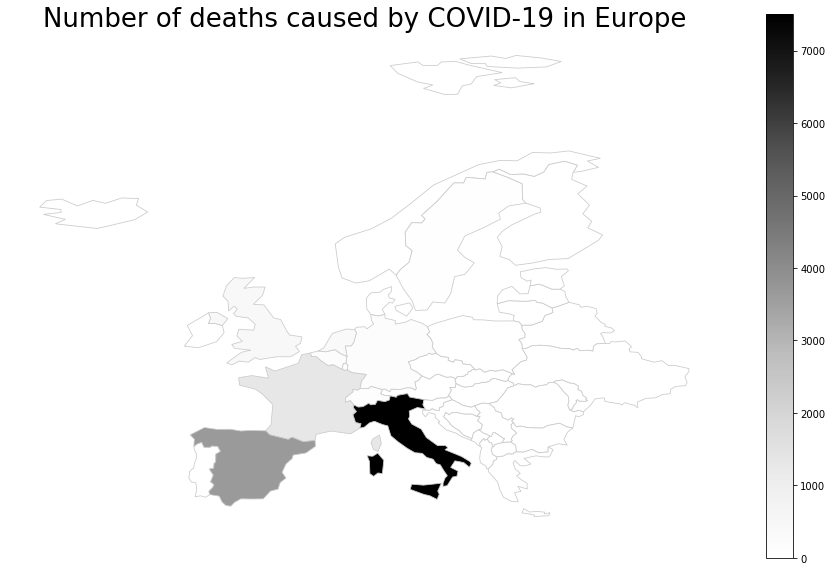

In [24]:
plot_map("Confirmed", europe_stats_df, "Number of confirmed cases of COVID-19 in Europe")
plot_map("Deaths", europe_stats_df, "Number of deaths caused by COVID-19 in Europe")   

### Getting population dataframe (data from https://worldpopulationreview.com/)

In [25]:
population_df = pd.read_csv("popultion.csv")[['name', 'pop2020']]
population_df["pop2020"] *= 1000
population_df = population_df.astype({'pop2020': 'int32'}, copy=False)
print('Population of Poland is:', population_df.loc[population_df['name'] == 'Poland', "pop2020"].values[0])
population_df.head()

Population of Poland is: 37846611


,name,pop2020
0,China,1439323776
1,India,1380004385
2,United States,331002651
3,Indonesia,273523615
4,Pakistan,220892340


### Preparing population dataframe data (unify countries names)

In [26]:
countries_proper_names = {
    'DR Congo': 'Congo',
    'South Korea': 'Korea, Republic of',
    'Ivory Coast': 'Côte d\'Ivoire',
    'North Korea': 'Korea, Democratic People\'s Republic of',
    'Laos': 'Lao People\'s Democratic Republic',
    'Swaziland': 'Eswatini',
    'Macau': 'Macao',
    'Cape Verde': 'Cabo Verde',
    'United States Virgin Islands': 'United States',
}


population_df.replace({'name': countries_proper_names}, inplace=True)
new_countries_names = [pycountry.countries.search_fuzzy(country)[0].name for country in population_df['name']]
population_df['name'] = new_countries_names
population_df = population_df.groupby('name', as_index=False).sum()
population_df.head()

,name,pop2020
0,Afghanistan,38928346
1,Albania,2877797
2,Algeria,43851044
3,American Samoa,55191
4,Andorra,77265


### Merging population dataframe with latest WHO report dataframe

In [27]:
latest_report_with_population = latest_report.join(population_df.set_index("name"), on='Country/Region')
# drop rows where pop2020 is NaN if there still are any
latest_report_with_population = latest_report_with_population.dropna(axis='index')
latest_report_with_population.head()

,Country/Region,Confirmed,Deaths,Recovered,pop2020
0,Afghanistan,84,2,2,38928346
1,Albania,146,5,17,2877797
2,Algeria,302,21,65,43851044
3,Andorra,188,1,1,77265
4,Angola,3,0,0,32866271


### Calculating percentages of separate countries populations disease statistics

In [28]:
latest_report_with_population["Confirmed percentage"] = latest_report_with_population["Confirmed"] / latest_report_with_population["pop2020"]
latest_report_with_population["Deaths percentage"] = latest_report_with_population["Deaths"] / latest_report_with_population["pop2020"]
latest_report_with_population["Recovered percentage"] = latest_report_with_population["Recovered"] / latest_report_with_population["pop2020"]
latest_report_with_population.head()

,Country/Region,Confirmed,Deaths,Recovered,pop2020,Confirmed percentage,Deaths percentage,Recovered percentage
0,Afghanistan,84,2,2,38928346,2.157811e-06,5.137644e-08,5.137644e-08
1,Albania,146,5,17,2877797,5.073325e-05,1.737440e-06,5.907296e-06
2,Algeria,302,21,65,43851044,6.886951e-06,4.788940e-07,1.482291e-06
3,Andorra,188,1,1,77265,2.433184e-03,1.294247e-05,1.294247e-05
4,Angola,3,0,0,32866271,9.127899e-08,0.000000e+00,0.000000e+00


### Merging world map dataframe with prepared dataframe containing percentage statistics

In [29]:
world_map_with_disease_percentage_data = world_map_df.join(latest_report_with_population.set_index("Country/Region"), on="name")
# Fill disease data for countries not included in report with 0
world_map_with_disease_percentage_data.fillna(0, inplace=True)

### Displaying most and least infected countries

In [30]:
max_infected = latest_report_with_population.sort_values(by=['Confirmed percentage'], ascending=False).iloc[:10, :]
print('Countries with maximal percentage of population infected:\n')
for i in range(10):
    print(max_infected.iloc[i, :]['Country/Region'], '-', max_infected.iloc[i, :]['Confirmed percentage'])

Countries with maximal percentage of population infected:

San Marino - 0.006130087530576759
Holy See (Vatican City State) - 0.004993757802746567
Andorra - 0.0024331844949200803
Iceland - 0.0021597512622969555
Luxembourg - 0.0021294678087728325
Liechtenstein - 0.0013375996642887118
Switzerland - 0.0012590960067348984
Italy - 0.0012302969480280004
Spain - 0.0010590361481344218
Monaco - 0.0007899699301768513


In [31]:
min_infected = latest_report_with_population.sort_values(by=['Confirmed percentage']).iloc[:10, :]
print('Countries with minimal percentage of population infected (among ones with infected ppl):\n')
for i in range(10):
    print(min_infected.iloc[i, :]['Country/Region'], '-', min_infected.iloc[i, :]['Confirmed percentage'])

Countries with minimal percentage of population infected (among ones with infected ppl):

Somalia - 6.291990384328615e-08
Sudan - 6.841620588352004e-08
Angola - 9.127898933225494e-08
Mali - 9.876136947057931e-08
Nepal - 1.0296254826541054e-07
Ethiopia - 1.0438087579521266e-07
Papua New Guinea - 1.1176900833170896e-07
Libya - 1.4553303803709696e-07
Mozambique - 1.5997217763886505e-07
Chad - 1.8263879452551173e-07


### Plotting percentage disease data on world map

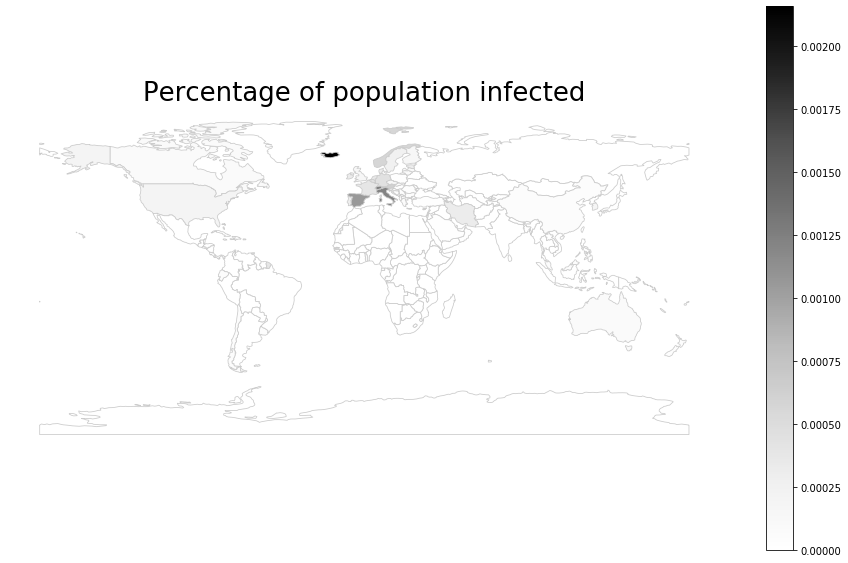

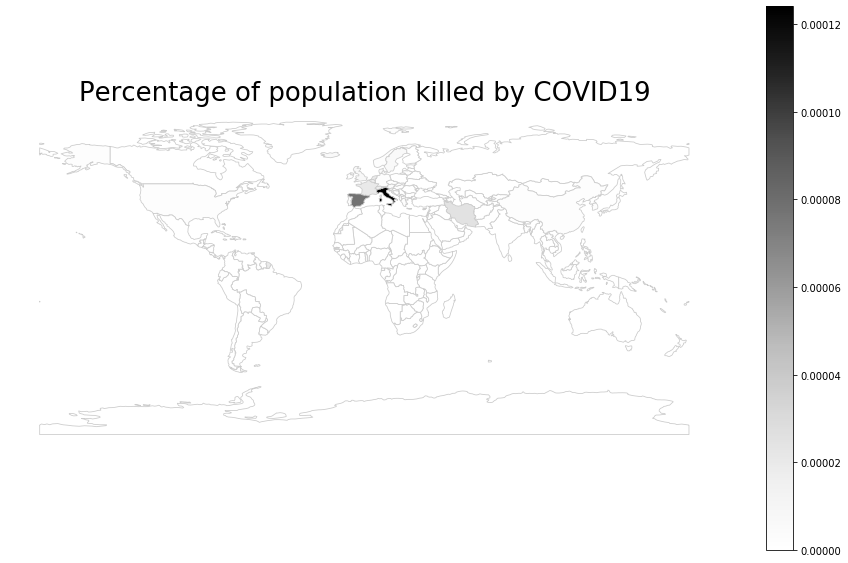

In [32]:
plot_map("Confirmed percentage", world_map_with_disease_percentage_data, "Percentage of population infected")
plot_map("Deaths percentage", world_map_with_disease_percentage_data, "Percentage of population killed by COVID19")

### Displaying most and least infected European countries 

In [33]:
europe_map_with_disease_percentage_data = world_map_with_disease_percentage_data.loc[world_map_with_disease_percentage_data['continent'] == 'Europe', :].copy()
france_geometry_values = europe_map_with_disease_percentage_data.loc[europe_map_with_disease_percentage_data['name'] == 'France', 'geometry'].values
france_geometry_values[0] = france_geometry_values[0][1:]
europe_map_with_disease_percentage_data.loc[europe_map_with_disease_percentage_data['name'] == 'France', 'geometry'] = france_geometry_values

In [34]:
max_infected_europe = europe_map_with_disease_percentage_data.sort_values(by=['Confirmed percentage'], ascending=False).iloc[:10, :]
print('European countries with maximal percentage of population infected:\n')
for i in range(10):
    print(max_infected_europe.iloc[i, :]['name'], '-', max_infected_europe.iloc[i, :]['Confirmed percentage'])

European countries with maximal percentage of population infected:

Iceland - 0.0021597512622969555
Luxembourg - 0.0021294678087728325
Switzerland - 0.0012590960067348984
Italy - 0.0012302969480280004
Spain - 0.0010590361481344218
Austria - 0.0006204478194279222
Norway - 0.0005688734369123232
Germany - 0.0004454672233015725
Belgium - 0.0004259845208079676
France - 0.0003881937541747888


In [35]:
min_infected_europe = europe_map_with_disease_percentage_data.sort_values(by=['Confirmed percentage']).iloc[:10, :]
print('European countries with minimal percentage of population infected:\n')
for i in range(10):
    print(min_infected_europe.iloc[i, :]['name'], '-', min_infected_europe.iloc[i, :]['Confirmed percentage'])

European countries with minimal percentage of population infected:

Ukraine - 3.315516282363269e-06
Russian Federation - 4.508873305059363e-06
Belarus - 9.101181111070073e-06
Hungary - 2.3394595082518222e-05
Poland - 2.776998976209521e-05
Bulgaria - 3.4827936322443363e-05
Moldova, Republic of - 3.693638241104343e-05
Slovakia - 3.9563033620153117e-05
Serbia - 4.3949146717015905e-05
Serbia - 4.3949146717015905e-05


### Ploting percentage disease data on Europe map (excluding Russia and French Guiana for clarity)

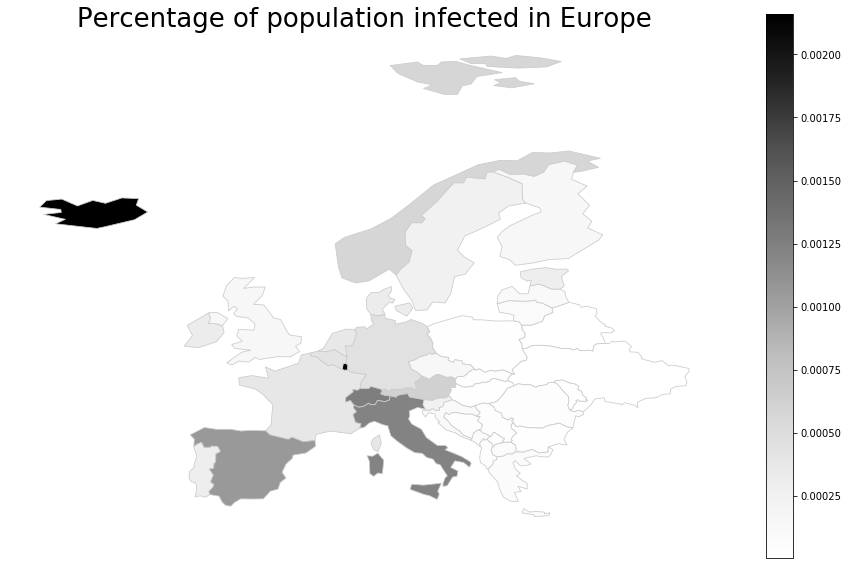

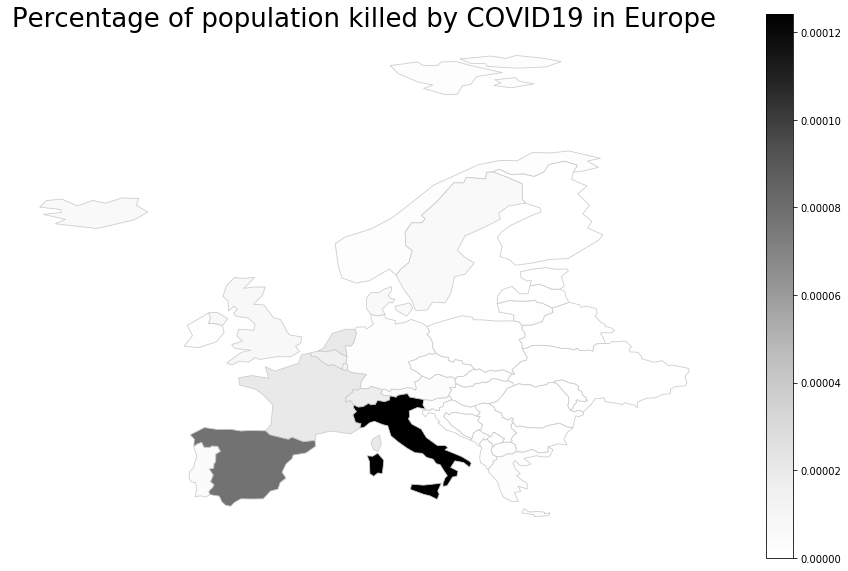

In [36]:
europe_map_with_disease_percentage_data = europe_map_with_disease_percentage_data.loc[europe_map_with_disease_percentage_data['name'] != 'Russian Federation', :]
plot_map("Confirmed percentage", europe_map_with_disease_percentage_data, "Percentage of population infected in Europe")
plot_map("Deaths percentage", europe_map_with_disease_percentage_data, "Percentage of population killed by COVID19 in Europe")